In [1]:
import numpy as np
import os
import math
import time
import mediapipe as mp
import cv2 as cv
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
# Holistic model
mp_holistic = mp.solutions.holistic
# Drawing utilities
mp_drawing = mp.solutions.drawing_utils 


In [3]:
path_train = "/Volumes/My Passport for Mac/2_Master2/PHOENIX-2014-T-release-v3/PHOENIX-2014-T/features/fullFrame-210x260px/train/"

In [4]:
folders_train = [folder[0] for folder in os.walk(path_train)]

In [5]:
def mediapipe_detection(image, model):
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv.cvtColor(image, cv.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [6]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [7]:
def draw_styled_landmarks(image, results):
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [8]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    # face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, lh, rh])

In [9]:
def get_keypoints(img):
# Set mediapipe model 
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        frame = img
        # Make detections
        image, results = mediapipe_detection(frame, holistic)
    return image, results
            
                

In [10]:
def draw_img_example(img):
    image, results = get_keypoints(img)
    # Draw landmarks
    draw_styled_landmarks(image, results)
    # Show to screen
    cv.imshow('OpenCV Feed', image)
    cv.destroyAllWindows()            
    draw_landmarks(image, results)
    plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))

In [11]:
def draw_keypoints_example(img):
    image, results = get_keypoints(img)
    # Draw landmarks
    draw_styled_landmarks(image, results)
    image_height, image_width = 256, 206
    image2 = np.zeros((image_height, image_width, 3), dtype=np.uint8)
    draw_landmarks(image2, results)
    plt.imshow(cv.cvtColor(image2, cv.COLOR_BGR2RGB))
    

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


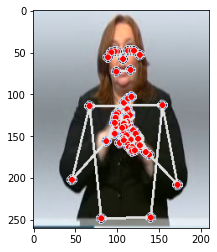

In [14]:
images = [image for image in os.walk(folders_train[1])]
for i in images[0][2]:
    img_path = str(folders_train[1])+'/'+str(i)
    img = cv.imread(img_path)
    if img is not None:
        draw_img_example(img)


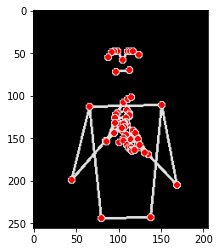

In [15]:
images = [image for image in os.walk(folders_train[1])]
for i in images[0][2]:
    img_path = str(folders_train[1])+'/'+str(i)
    img = cv.imread(img_path)
    if img is not None:
        draw_keypoints_example(img)

In [16]:
# interatively generate the keypoints for all images and save to folder
for f in range(1, 2): # len(folders_train)
    images = [image for image in os.walk(folders_train[f])]
    for i in images[0][2]:
        img_path = str(folders_train[f])+'/'+str(i)
        img = cv.imread(img_path)
        if img is not None:
            image, results = get_keypoints(img)
            # Draw landmarks
            draw_styled_landmarks(image, results)
            result_to_save = extract_keypoints(results)
            base_folder_path = 'test/'

            folder_path = os.path.join(base_folder_path, str(f+1))
            os.makedirs(folder_path, exist_ok=True)
                
            np.save(os.path.join(folder_path, str(i)), result_to_save)
            
            

In [17]:
test = np.load('test/2/images0001.png.npy')

In [18]:
#pose 132
#lh 63
#rh 63
pose = test[0:132]
lh = test[132:132+63]
rh = test[132+63:]


In [19]:
test.size

258

In [20]:
# Define the original shapes of the arrays
pose_shape = (33, 4)
hand_shape = (21, 3)

# Reshape the flattened arrays to their original shapes
pose_original = np.reshape(pose, pose_shape) if len(pose) > 0 else np.zeros(pose_shape)
lh_original = np.reshape(lh, hand_shape) if len(lh) > 0 else np.zeros(hand_shape)
rh_original = np.reshape(rh, hand_shape) if len(rh) > 0 else np.zeros(hand_shape)


In [21]:
pose_original2 = [{'x': x, 'y': y, 'z': z} for x, y, z, visibility in pose_original]
if lh_original is not None:
    lh_original2 = [{'x': x, 'y': y, 'z': z} for x, y, z in lh_original]
if rh_original is not None:
    rh_original2 = [{'x': x, 'y': y, 'z': z} for x, y, z in rh_original]

In [ ]:
# Create a black image to draw the keypoints on
image = np.zeros((500, 500, 3), dtype=np.uint8)

# Define the colors for the keypoints
pose_color = (0, 0, 255)  # Red color for pose keypoints
lh_color = (0, 255, 0)  # Green color for left hand keypoints
rh_color = (255, 0, 0)  # Blue color for right hand keypoints

# Draw pose keypoints
for point in pose_original2:
    x, y = int(point['x'] * image.shape[1]), int(point['y'] * image.shape[0])
    cv.circle(image, (x, y), 5, pose_color, -1)

# Draw left hand keypoints
if lh_original is not None:
    for point in lh_original2:
        x, y = int(point['x'] * image.shape[1]), int(point['y'] * image.shape[0])
        cv.circle(image, (x, y), 5, lh_color, -1)
else:
    print('left hand is not recognised')
# Draw right hand keypoints
if rh_original is not None:
    for point in rh_original2:
        x, y = int(point['x'] * image.shape[1]), int(point['y'] * image.shape[0])
        cv.circle(image, (x, y), 5, rh_color, -1)
else:
    print('right hand is not recognised')
# Display the image with keypoints
cv.imshow('Keypoints', image)
cv.waitKey(0)
cv.destroyAllWindows()

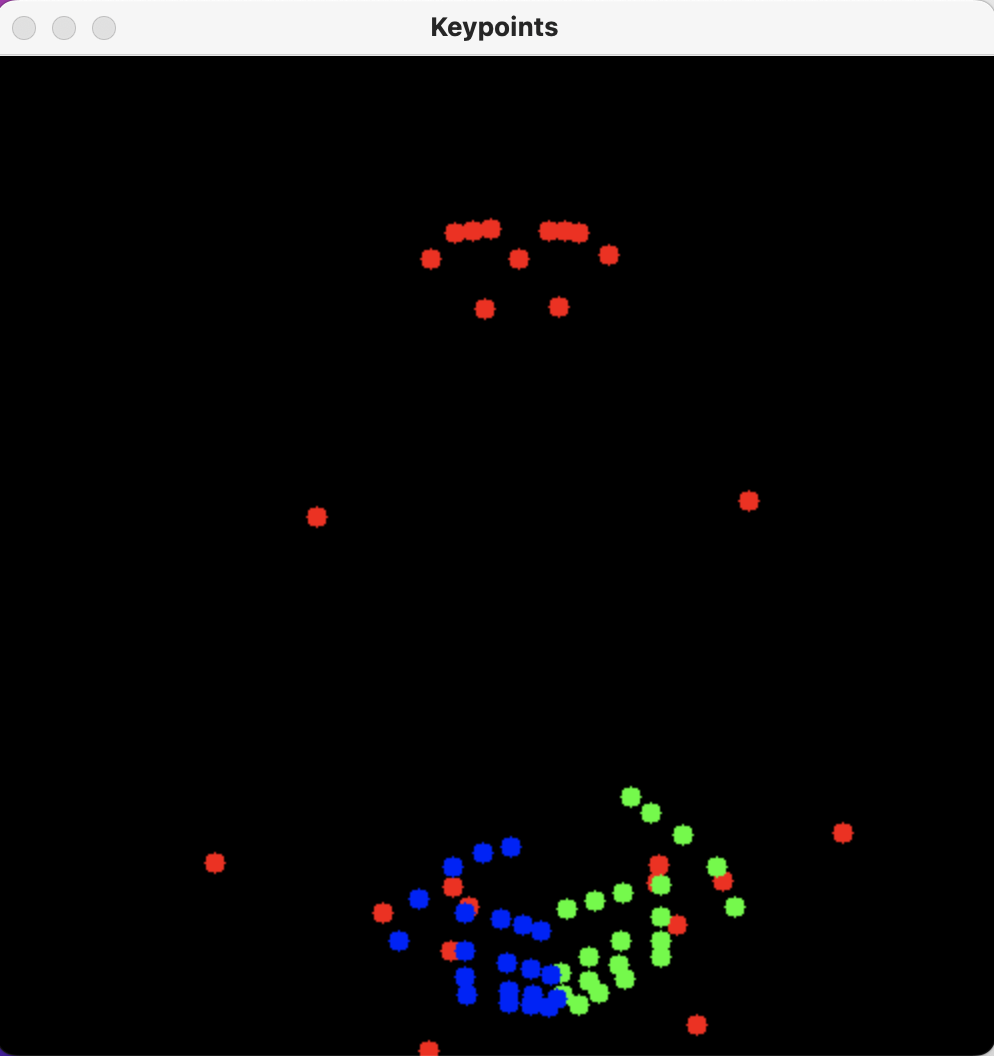